### Title

Efficient short-term memory for feature conjunctions in a random network without Hebbian plasticity

### Summary

Short-term memory is thought to play a key role in high-level cognition, but relative to that of other neural systems its mechanistic basis is poorly understood. While at least some degree of short-term memory exists in any off-the-shelf neural network with sufficiently strong recurrence, a particularly interesting computational problem is short-term memory for associations between multiple objects or features, since the space of such associations is quite large. Since Hebbian plasticity is thought to be too slow for the fast timescales required by short-term memory, one well-known approach to this problem has focused on temporal synchrony between associated neurons, but such a mechanism is intrinsically fragile and requires a nontrivial encoder and decoder. An alternative model motivated by the expressive power of distributing representations across many neurons assumes that associations are held in persistent distributed states, but it still requires training of an encoder and decoder to store and retrieve the associations. Here we show how a network with completely random connections between item units and a small reservoir of bistable memory units (containing far fewer units than possible conjunctions) can remember and recall multiple associations between items with excellent accuracy without any training or any separate encoder or decoder, and we demonstrate the model's biophysical plausibility by implementing it in a network of standard integrate-and-fire neurons. Fundamentally, the model relies on the compositionality of attractor states and on their ability to gate information transmission, and it predicts that short-term memory is limited primarily by the overlap of persistent brain states encoding different pieces of information. Importantly, the model illustrates how pre-existing, untrained connections to a reservoir of memory units could subserve a high-level cognitive task, thus lowering the architectural complexity required for this important brain function.

/Users/rkp/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


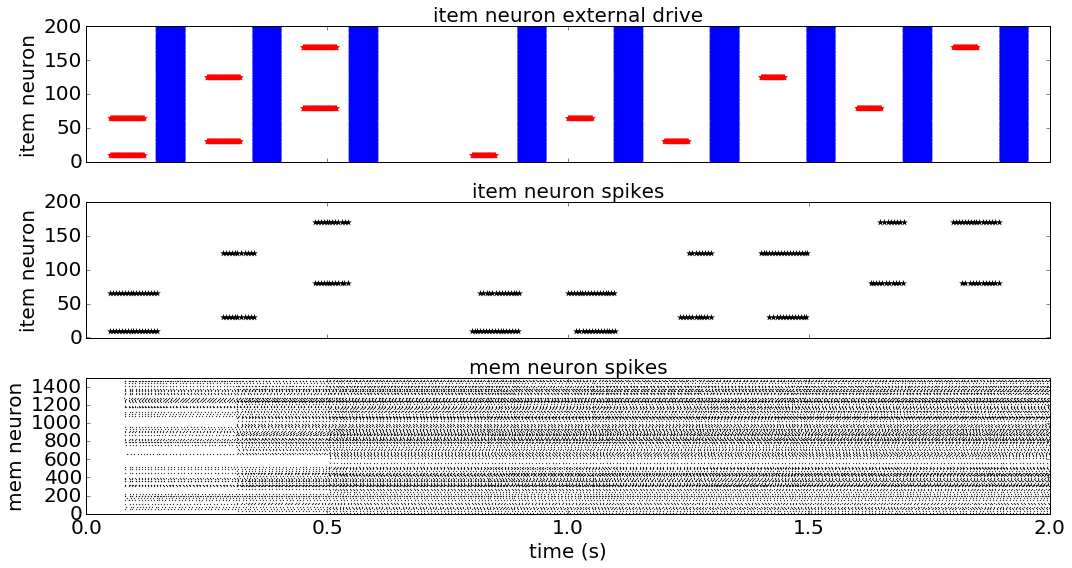

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from network import LIFWithKWTAItems
from plot import set_fontsize

np.random.seed(0)

TAU = 0.03
V_REST = -0.07
V_TH = -0.02
V_RESET = -0.08
V_MIN = -0.1
T_RP = 0.005

V_REV_SYN_EXC = 0.0
TAU_SYN_EXC = 0.01

TAU_FRE = .05
K_WTA = 2
WTA_TH = 10.
WTA_INH = -.5
NOISE = 0.01

N_ITEMS = 200
N_ASSOCS = 1500
P_CXN = 0.15

cxn_ap = (np.random.rand(N_ITEMS, N_ASSOCS) < P_CXN).astype(float)

W_PA = 1. * cxn_ap

W_AP = 1. * cxn_ap.T

W_AM = np.eye(N_ASSOCS)
W_MA = 10 * np.eye(N_ASSOCS)
W_MM = 15 * np.eye(N_ASSOCS)

n_items = W_PA.shape[0]
n_assocs = W_PA.shape[1]
n_mems = W_MM.shape[0]

n_neurons = n_items + n_assocs + n_mems

ntwk = LIFWithKWTAItems(
    tau=TAU, v_rest=V_REST, v_th=V_TH, v_reset=V_RESET, v_min=V_MIN, t_rp=T_RP,
    v_rev_syn_exc=V_REV_SYN_EXC, tau_syn_exc=TAU_SYN_EXC,
    tau_fre=TAU_FRE, k_wta=K_WTA, wta_th=WTA_TH, wta_inh=WTA_INH, noise=NOISE,
    w_pa=W_PA, w_ap=W_AP, w_am=W_AM, w_ma=W_MA, w_mm=W_MM)

# drive

n_steps = 2000

drives = {}
drives['item'] = np.zeros((n_steps, n_items))

drives['item'][50:120, 10] = 2
drives['item'][50:120, 65] = 2
drives['item'][250:320, 30] = 2
drives['item'][250:320, 125] = 2
drives['item'][450:520, 80] = 2
drives['item'][450:520, 170] = 2
drives['item'][800:850, 10] = 2
drives['item'][1000:1050, 65] = 2
drives['item'][1200:1250, 30] = 2
drives['item'][1400:1450, 125] = 2
drives['item'][1600:1650, 80] = 2
drives['item'][1800:1850, 170] = 2

drives_item_no_inh = drives['item'].copy()

drives_item_inh = np.zeros((n_steps, n_items))

drives_item_inh[150:200, :] = -10
drives_item_inh[350:400, :] = -10
drives_item_inh[550:600, :] = -10
drives_item_inh[900:950, :] = -10
drives_item_inh[1100:1150, :] = -10
drives_item_inh[1300:1350, :] = -10
drives_item_inh[1500:1550, :] = -10
drives_item_inh[1700:1750, :] = -10
drives_item_inh[1900:1950, :] = -10

drives['item'] += drives_item_inh

v_init = V_REST * np.ones((n_neurons,))
g_init = np.zeros((n_neurons,))
dt = 0.001

results, ts = ntwk.run(drives, v_init, g_init, dt, record=['spikes', 'vs', 'fre_items'])


## MAKE PLOTS

fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True, tight_layout=True)

drive_times, drive_idxs = drives_item_no_inh.nonzero()
inh_times, inh_idxs = drives_item_inh.nonzero()

axs[0].scatter(drive_times * dt, drive_idxs, marker='*', s=50, c='r', lw=0)
axs[0].scatter(inh_times * dt, inh_idxs, marker='*', s=50, c='b', lw=0)

axs[0].set_ylim(-1, n_items)

axs[0].set_ylabel('item neuron')

axs[0].set_title('item neuron external drive')

spike_times, spike_idxs = results['spikes'][:, :n_items].nonzero()

axs[1].scatter(spike_times * dt, spike_idxs, marker='*', s=50, c='k', lw=0)
axs[1].set_xlim(0, n_steps * dt)
axs[1].set_ylim(-1, n_items)

axs[1].set_ylabel('item neuron')
axs[1].set_title('item neuron spikes')

spike_times, spike_idxs = results['spikes'][:, n_items+n_assocs:n_items+n_assocs+n_mems].nonzero()

axs[2].scatter(spike_times * dt, spike_idxs, marker='*', s=4, c='k', lw=0)

axs[2].set_ylim(-1, n_mems)

axs[2].set_xlabel('time (s)')
axs[2].set_ylabel('mem neuron')

axs[2].set_title('mem neuron spikes')

for ax in axs:
    
    set_fontsize(ax, 20)

### Capacity analysis

capacity_analysis.py:40: RuntimeWarning: invalid value encountered in subtract
  log_x_normed = log_xs - log_x_max
capacity_analysis.py:167: RuntimeWarning: invalid value encountered in less
  approx_mask = temp_1 < np.log(-np.log(1 - 1e-9))


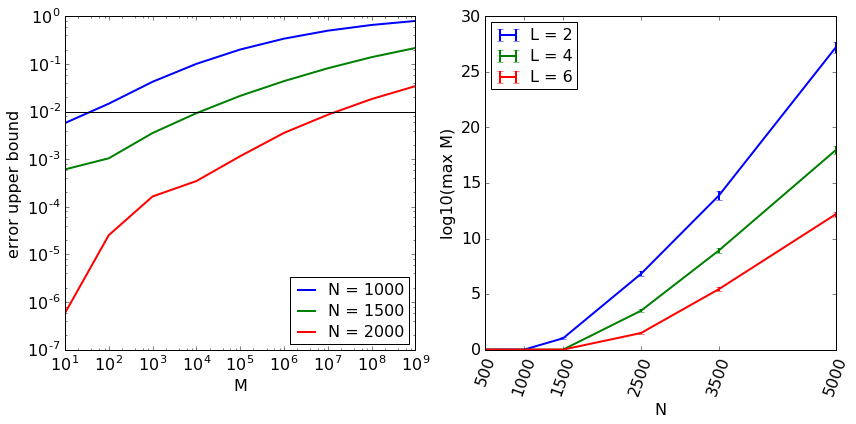

In [2]:
%matplotlib inline
from figures.cosyne import capacity_analysis

fig = capacity_analysis(
    SEED=0,
    Q=0.15,
    L_EXAMPLE=4,
    NS_EXAMPLE=[1000, 1500, 2000],
    MS_EXAMPLE=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9],
    ERR_MAX_EXAMPLE=0.01,
    NS=[500, 1000, 1500, 2500, 3500, 5000],
    LS=[2, 4, 6],
    ERR_MAX=0.000001,
    M_TOL=0.01,
    N_SAMPLES_MC=5000,
    N_TRIALS=30)